# DS2 Take-Home Assignment - Nicolas Fernandez
### Kaggle Competition - Predicting Online News Popularity
The task is to create the best possible model for predicting the popularity of a news article from mashable.com and perform best in a kaggle.com competition being held.

The dataset being used can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/data) and a link to the kaggle competition overview can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/overview).

The data itself, as mentioned above, comes from mashable.com and is data from articles that appeared on the site two years past January 8, 2015 (when the dataset was acquired) or later. The goal is to predict which articles are shared the most on social media using the binary `is_popular` column within the dataset denoting an article being popular with a 1, 0 if not. From the competition, the data is already split into `train.csv` and `test.csv` with the latter being used to generate predictions on popularity for submission to the competition. `train.csv` will be split into training and test sets for creating and testing predictive models.

Both the train and test csv's have a column `article_id` that is solely the index of the articles in the data. This will be used as the index for the dataframes when loaded in. The numbers don't exactly match up with the amount of observations in the dataset but that's not a problem. This will be necessary later when creating the Kaggle submission.

The submission scores will be calculated using AUC scores as the loss function per specifications of the competition.

## Loading Data and EDA

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np

# Loading train data from csv locally and viewing the contents
raw_data = pd.read_csv('train.csv', index_col='article_id')
display(raw_data.head())
raw_data.info()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular
article_id,,,,,,,,,,,,,,,,,,,,,
1,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,0.10,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0
3,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,0.05,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0
5,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.10,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0
6,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.10,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0
7,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.05,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 29733 entries, 1 to 39643
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null  int6

There are no NaN values within the data however there could imputed values that can be interpreted as missing. This will be explored further. One question to be explored if a dummy variable is necessary for each day of the week or only weekends are important, and same for the genre of the article.

First however is to check the correlation of the features of this dataset.

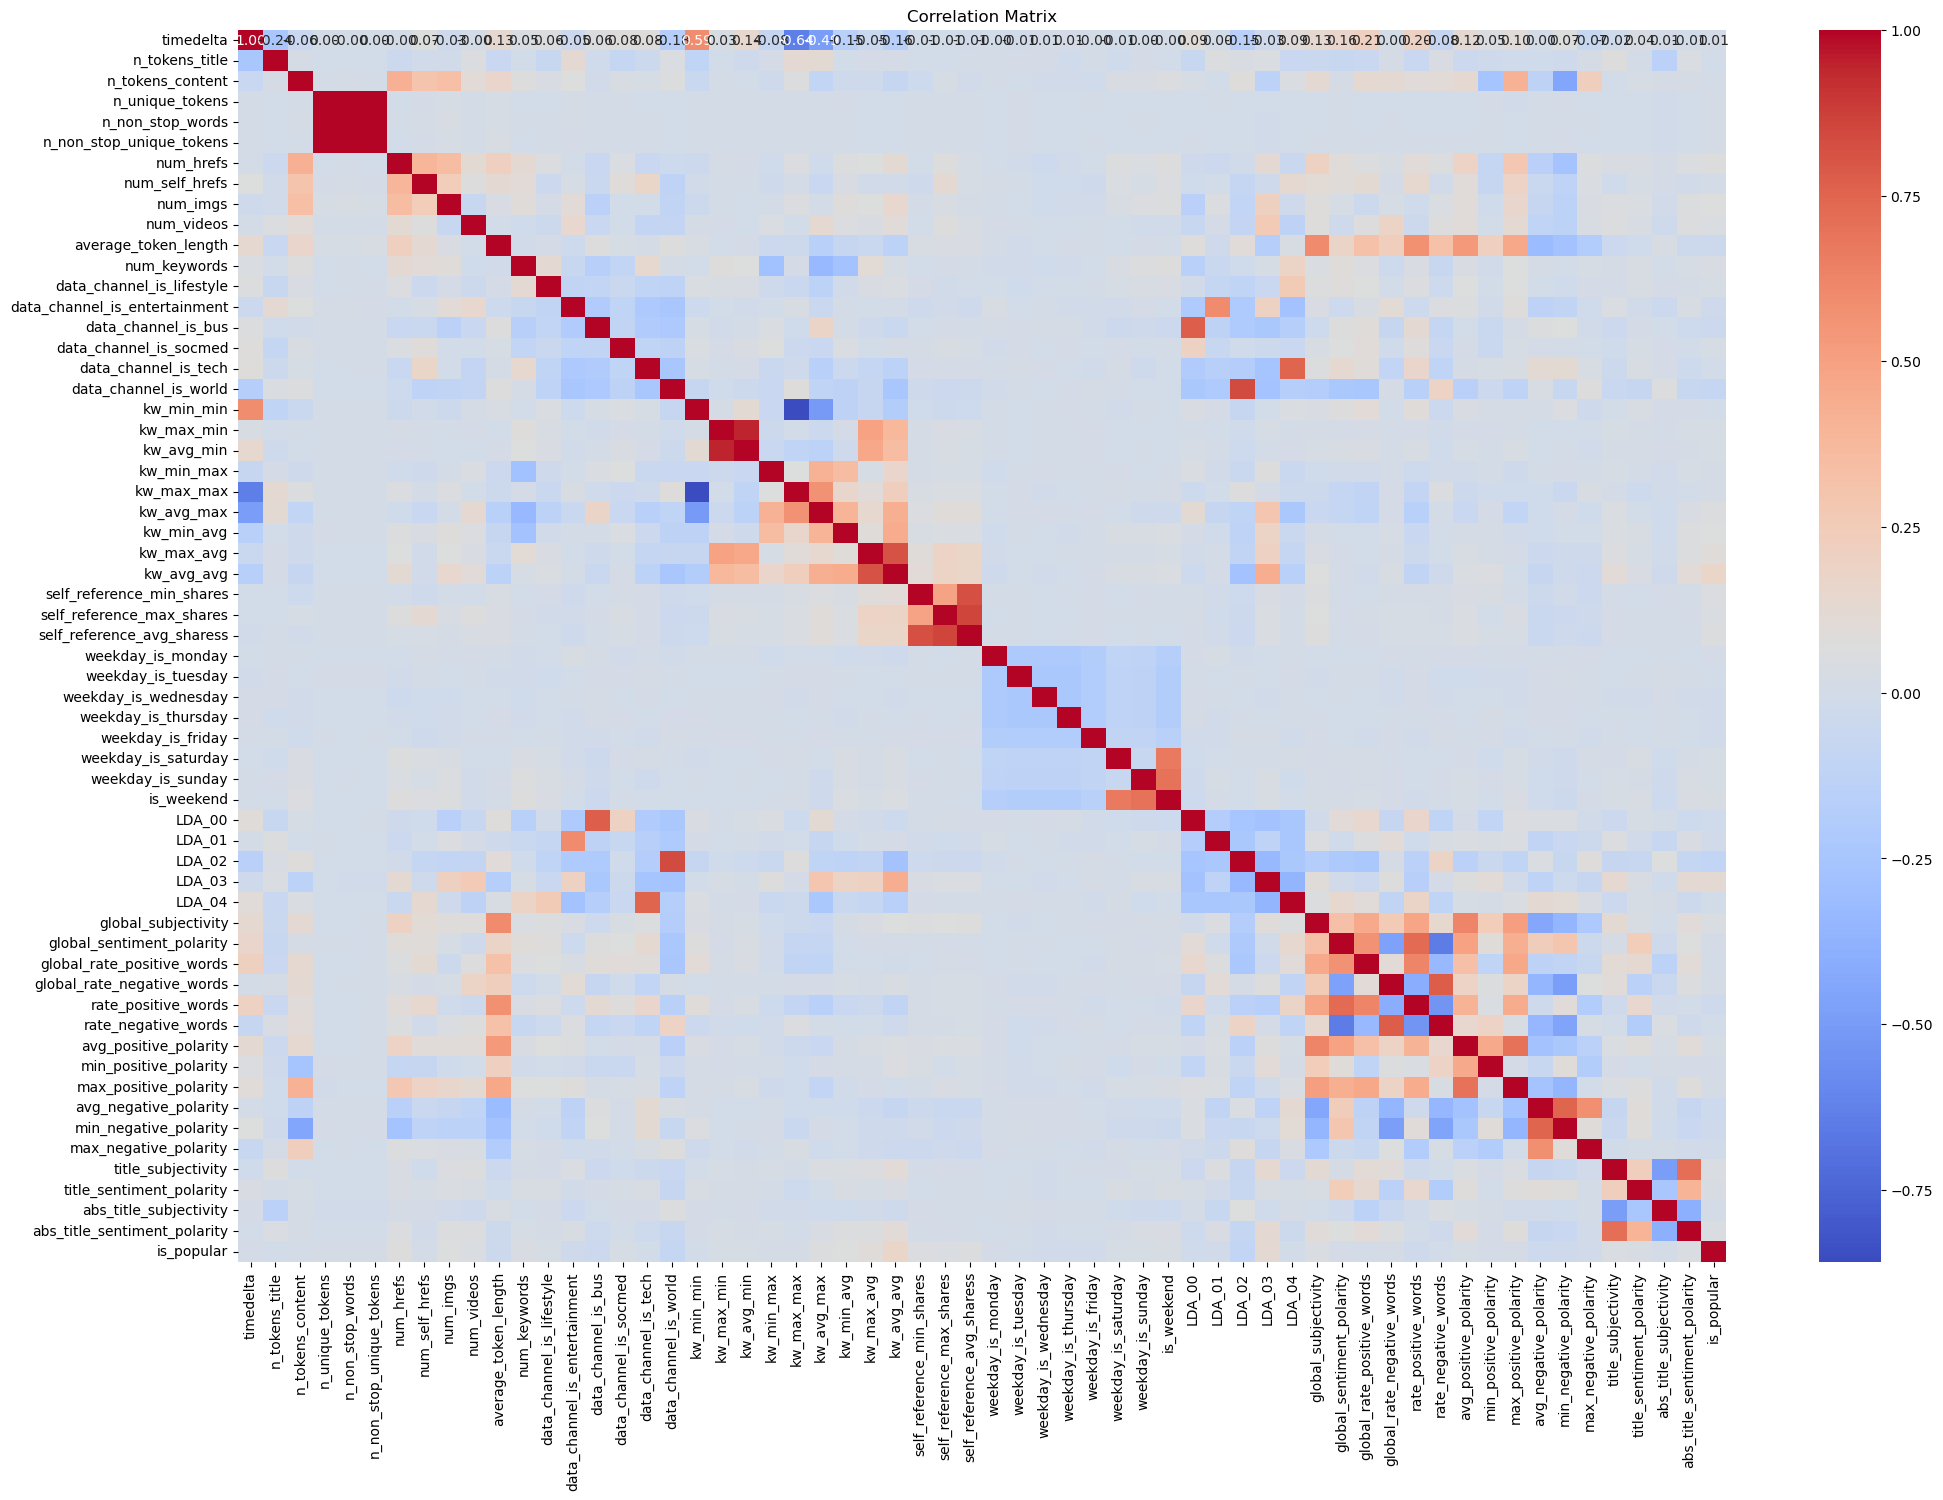

In [2]:
# Importing required libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a correlation matrix plot
plt.figure(figsize=(24,16))
sns.heatmap(raw_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

plt.show()

From viewing the correlation matrix, we can infer the following:
- The `LDA_` columns refer specifically to the closeness of the article of a genre specified in the data. `LDA_00` refers to Business, `LDA_01` to Entertainment, `LDA_02` to World, and `LDA_04` to Tech. `LDA_03` given this ordering would imply it refers to Social Media however it does not appear to be significantly correlated as such. In any case these variables are now interpretable and will be kept.
- Amongst all the `kw_` columns, the `kw_avg_avg` column is positively correlated with all other `kw_` columns. Therefore out of all of these columns only `kw_avg_avg` will be kept as it is also the most interpretable of the features since it is the average amount of shares of all keywords in an article
- The `self_reference` columns are all highly correlated to each other. From these three, only `self_reference_avg_sharess` will be kept. This refers to the average shares of articles referenced within Mashable, which might be good for predicting for this dataset but also would harm any potential external validity for models trained on it
- Each `weekday_is_` column seems negatively correlated with each other except for Saturday and Sunday. This will be explored further below
- `n_unique_tokens`, `n_non_stop_unique_tokens`, and `n_non_stop_unique_tokens` are all extremely correlated. Only `n_unique_tokens` will be kept
- `num_hrefs` and `num_self_hrefs` are measuring similar things and are correlated. Only `num_hrefs` will be kept in an attempt to aid external validity since it refers to all links and not just links to other Mashable.com articles
- All of the `polarity` and `rate_positive/negative` columns are very correlated, either positively or negatively. Only the global rates and average columns out of these will be kept to make sure this information is captured without too many redundancies
- For the `title_` columns, the `abs_` columns will be dropped as they are harder to interpret and also are captured already in the previous two features

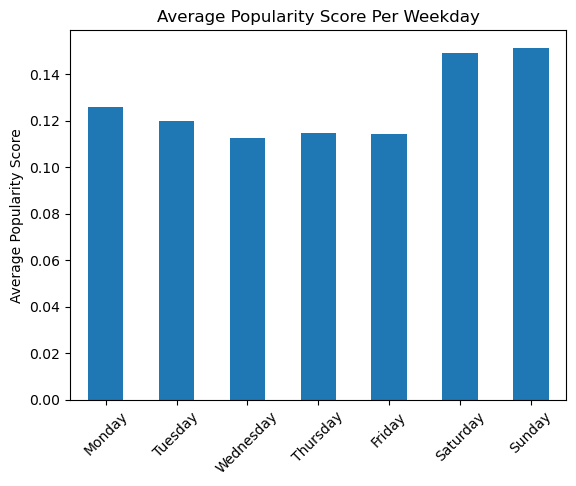

In [3]:
# Creating a copy of raw_data to preserve it just in case
data = raw_data.copy()

# Creating list of features to exclude from initial feature selection
exclude_cols = []
for col in data.columns:
    if col.startswith('kw_') and col != 'kw_avg_avg':
        exclude_cols.append(col)
    elif col.startswith('self_') and not 'avg' in col:
        exclude_cols.append(col)
    elif col.startswith('n_non_'):
        exclude_cols.append(col)
    elif col == 'num_self_href':
        exclude_cols.append(col)
    elif col.startswith('rate_'):
        exclude_cols.append(col)
    elif 'polarity' in col and not col.startswith('avg') and not col.startswith('global') and not col.startswith('title'):
        exclude_cols.append(col)
    elif 'subjectivity' in col and not col.startswith('global') and not col.startswith('title'):
        exclude_cols.append(col)

# Getting all weekday columns set to a list
weekdays = [col for col in data.columns if col.startswith('weekday_')]
weekday_names = [day.replace('weekday_is_', '').capitalize() for day in weekdays]

# Creating dataframe that shows average popularity score for each weekday
avg_weekday_pop_df = data.groupby(weekdays)['is_popular'].mean()[::-1]

# Creating a bar plot to show the average scores per weekday
avg_weekday_pop_df.plot(kind='bar')
plt.xlabel(None)
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score Per Weekday')

plt.xticks(range(len(weekday_names)), weekday_names, rotation=45)

plt.show()

From this plot we can see that the most influential days from the data are the weekends (Saturday and Sunday) with the earlier weekdays being slightly more influential than the latter ones. Using this information, the dummy variables for each weekday will be dropped, the already existing `is_weekend` column will be kept but renamed to `d_weekend` to flag it as a dummy variable, and a new dummy variable `d_mon_tues` will be created to flag whether the article was released on either Monday or Tuesday.

Next, the same examination will be done for article genres.

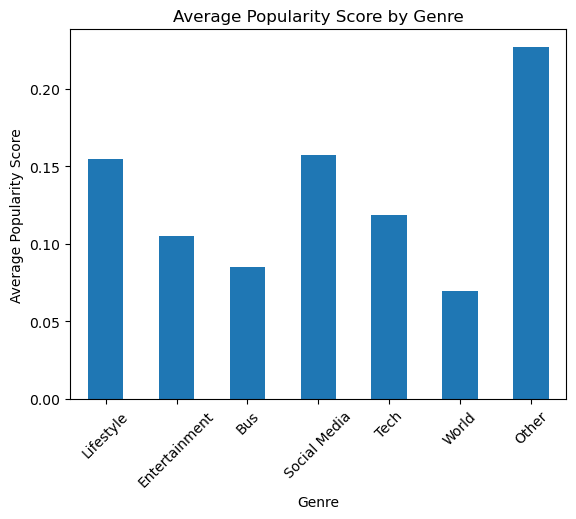

In [4]:
# Creating Monday/Tuesday dummy variable
data['d_mon_tues'] = data['weekday_is_monday'] + data['weekday_is_tuesday']

# Renaming is_weekend to d_weekend
data.rename(columns={'is_weekend': 'd_weekend'}, inplace=True)

# Dropping all weekday_is_ columns from data since they are no longer necessary
data.drop(columns=weekdays, inplace=True)

# Repeating the same plot above but with article genres
genres = [col for col in data.columns if col.startswith('data_channel_is_')]
genre_names = [genre.replace('data_channel_is_', '').capitalize() for genre in genres]
genre_names[genre_names.index('Socmed')] = 'Social Media'
genre_names.append('Other')

genre_pop_df = data.groupby(genres)['is_popular'].mean()[::-1]

genre_pop_df.plot(kind='bar')

plt.xlabel('Genre')
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score by Genre')

plt.xticks(range(len(genre_names)), genre_names, rotation=45)

plt.show()

From reviewing the data there were a couple observations:
- Despite there being 6 genre classifiers in the data there is a 7th occurence for articles that don't fall under any of the labelled genres. For the purposes of the plot they were labelled as `Other`
- Articles not falling into any of the 6 classified genres are significantly more popular than the rest
- Amongst the articles denoted by a specific genre, the `Lifestyle` and `Social Media` genres are the most significant predictors, roughly the same
- The `World` genre appears to be the least popular genre, somewhat significantly so

From this analysis it appears that the genre of the article has significance for determining popularity but that different groupings may not make sense. These columns will be left as is within the data but renamed to flag them as dummy variables with the following syntax: `d_genre_`

Next a histogram of the `average_token_length` will be examined.

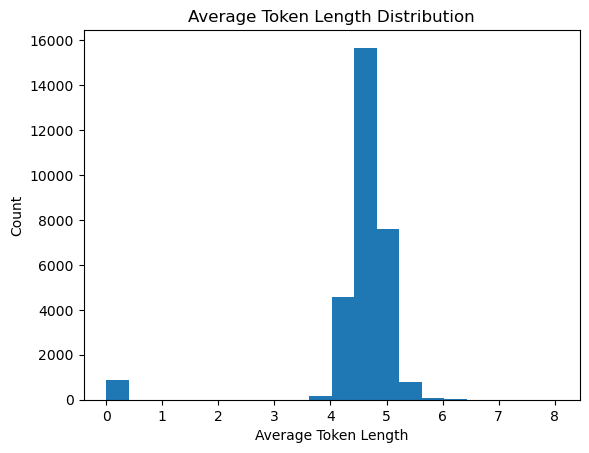

In [5]:
# Renaming genre dummy variables
[data.rename(columns={genre: genre.replace('data_channel_is_', 'd_genre_')}, inplace=True) for genre in genres]

# Generating a historgram of `average_token_length`
plt.hist(data['average_token_length'], bins=20)

plt.xlabel('Average Token Length')
plt.ylabel('Count')
plt.title('Average Token Length Distribution')

plt.show()

From this we can see that the distribution of average token length of articles in the data is approximating a normal distribution around a mean of roughly 4.5. The noteworthy values here are the significant portion of values with an average token length of 0. These occurrences will be explored in more depth to figure out what exactly these represent. It is likely that these articles are slideshows and/or videos rather than traditional prose (or a combination thereof).

In [6]:
# Viewing descriptive statistics for occurences where `average_token_length` equals 0
data[data['average_token_length'] == 0].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,d_mon_tues
count,867.000000,867.000000,867.0,867.0,867.0,867.0,867.0,867.0,867.000000,867.000000,...,867.0,867.0,867.0,867.0,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,164.573241,10.850058,0.0,0.0,0.0,0.0,0.0,0.0,3.747405,0.792388,...,0.0,0.0,0.0,0.0,0.349305,0.088811,0.317413,0.194028,0.191465,0.359862
std,167.269141,2.036760,0.0,0.0,0.0,0.0,0.0,0.0,8.606464,1.155682,...,0.0,0.0,0.0,0.0,0.339876,0.295841,0.193348,0.240267,0.393681,0.480237
min,9.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,57.500000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000
50%,101.000000,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.333333,0.000000,0.400000,0.125000,0.000000,0.000000
75%,191.000000,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.600000,0.250000,0.500000,0.300000,0.000000,1.000000
max,715.000000,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,24.000000,...,0.0,0.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000


In [7]:
# Viewing descriptive statistics for occurrences where `average_token_length` is not equal to 0
data[data['average_token_length'] != 0].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,d_mon_tues
count,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,...,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000
mean,361.384570,10.377018,561.377780,0.571748,1.036063,0.716319,11.240456,3.389628,4.547876,1.277697,...,0.780540,-0.267509,-0.536629,-0.111030,0.279852,0.069116,0.342149,0.154069,0.119552,0.354847
std,212.907893,2.110788,466.609145,4.124008,6.127135,3.823021,11.323671,3.854916,8.200756,4.246004,...,0.212662,0.122140,0.280179,0.095229,0.322743,0.263360,0.188551,0.224494,0.324443,0.478475
min,8.000000,2.000000,18.000000,0.114964,1.000000,0.119134,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,174.250000,9.000000,258.000000,0.477781,1.000000,0.632886,5.000000,1.000000,1.000000,0.000000,...,0.600000,-0.331818,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000
50%,350.000000,10.000000,422.000000,0.543646,1.000000,0.693767,8.000000,3.000000,1.000000,0.000000,...,0.800000,-0.256944,-0.500000,-0.100000,0.125000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,548.000000,12.000000,725.000000,0.611792,1.000000,0.757322,14.000000,4.000000,4.000000,1.000000,...,1.000000,-0.193056,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000,0.000000,1.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,74.000000,111.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000


Viewing of the descriptive statistics of the two scenarios it appears as if the original assumption was correct, that these occurrences in the data are slideshows and/or videos with no text in the content. They cannot be dropped however as they are clearly not errors in the data entry. A dummy variable `d_no_words` will be created to represent this scenario.

Another thing noted from the non-zero average token length is that the standard deviation of `n_tokens_content` is very large. For reference, the values at and above the 99% range will be viewed closer.

In [8]:
# Creating a dummy variable for when `average_token_length` is equal 0
data['d_no_words'] = (data['average_token_length'] == 0).astype(int)

# Calculating the 95% of n_tokens_content
content_99 = data['n_tokens_content'].quantile(.99)

# Viewing descriptive statistics at and above 99% quantile value
data[data['n_tokens_content'] >= content_99].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,d_mon_tues,d_no_words
count,298.000000,298.000000,298.000000,298.000000,2.980000e+02,298.000000,298.000000,298.000000,298.000000,298.000000,...,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.0
mean,342.788591,10.479866,2976.929530,0.327987,1.000000e+00,0.494121,30.875839,8.278523,18.073826,4.348993,...,-0.284523,-0.865257,-0.052762,0.304710,0.128655,0.336460,0.171020,0.187919,0.362416,0.0
std,189.989010,2.412355,918.705812,0.057942,1.237282e-10,0.083742,28.304287,9.485392,21.441988,14.483208,...,0.057095,0.164475,0.029523,0.333556,0.270272,0.189578,0.245578,0.391305,0.481507,0.0
min,8.000000,5.000000,2258.000000,0.114964,1.000000e+00,0.129263,0.000000,0.000000,0.000000,0.000000,...,-0.473922,-1.000000,-0.400000,0.000000,-0.600000,0.000000,0.000000,0.000000,0.000000,0.0
25%,185.750000,9.000000,2430.750000,0.298184,1.000000e+00,0.461614,10.000000,2.000000,1.000000,0.000000,...,-0.319522,-1.000000,-0.050000,0.000000,0.000000,0.152327,0.000000,0.000000,0.000000,0.0
50%,320.000000,11.000000,2671.000000,0.332264,1.000000e+00,0.500000,21.000000,5.000000,10.000000,0.000000,...,-0.273092,-1.000000,-0.050000,0.233333,0.000000,0.500000,0.005976,0.000000,0.000000,0.0
75%,480.500000,12.000000,3138.250000,0.365665,1.000000e+00,0.549221,43.000000,12.000000,30.750000,1.000000,...,-0.240777,-0.800000,-0.050000,0.500000,0.250000,0.500000,0.283036,0.000000,1.000000,0.0
max,713.000000,18.000000,8474.000000,0.462878,1.000000e+00,0.672108,159.000000,74.000000,111.000000,75.000000,...,-0.134524,-0.155556,-0.008333,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,0.0


In [9]:
# Viewing descriptive statistics at 75% quartile and below
content_75 = data['n_tokens_content'].quantile(.75)
data[data['n_tokens_content'] <= content_75].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,d_mon_tues,d_no_words
count,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,...,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000
mean,364.375516,10.378206,338.894081,0.563366,0.961121,0.695123,8.791704,2.754933,3.370628,1.028879,...,-0.253503,-0.458067,-0.119923,0.280851,0.067488,0.340745,0.152125,0.119327,0.357354,0.038879
std,216.259182,2.089012,174.042729,0.140219,0.193311,0.164975,8.145548,2.432475,5.950367,3.205206,...,0.141229,0.281218,0.105838,0.322381,0.259226,0.189330,0.220477,0.324181,0.479231,0.193311
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,170.000000,9.000000,209.000000,0.520773,1.000000,0.660606,4.000000,1.000000,1.000000,0.000000,...,-0.331944,-0.600000,-0.150000,0.000000,0.000000,0.165584,0.000000,0.000000,0.000000,0.000000
50%,355.000000,10.000000,318.000000,0.572816,1.000000,0.716783,6.000000,2.000000,1.000000,0.000000,...,-0.245833,-0.500000,-0.100000,0.144444,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
75%,558.000000,12.000000,466.000000,0.632083,1.000000,0.775510,11.000000,4.000000,2.000000,1.000000,...,-0.166667,-0.250000,-0.050000,0.500000,0.136364,0.500000,0.250000,0.000000,1.000000,0.000000
max,731.000000,19.000000,712.000000,1.000000,1.000000,1.000000,118.000000,65.000000,100.000000,59.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Viewing the last 20 observations when sorted by n_tokens_content
data.sort_values('n_tokens_content').tail(20)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,d_mon_tues,d_no_words
article_id,,,,,,,,,,,,,,,,,,,,,
28698,399,8,4155,0.315675,1.0,0.547187,7,0,1,0,...,-0.219591,-1.0,-0.012500,0.062500,0.000000,0.437500,0.000000,0,0,0
36127,427,14,4172,0.312469,1.0,0.498939,25,3,1,0,...,-0.235841,-1.0,-0.050000,0.266667,0.066667,0.233333,0.066667,0,0,0
21810,217,8,4306,0.379726,1.0,0.593688,20,10,1,1,...,-0.353855,-1.0,-0.050000,0.000000,0.000000,0.500000,0.000000,0,0,0
6441,170,12,4331,0.304833,1.0,0.542174,5,0,1,0,...,-0.269213,-1.0,-0.050000,0.600000,0.700000,0.100000,0.700000,1,1,0
27810,146,10,4452,0.293559,1.0,0.482619,39,0,1,0,...,-0.282290,-0.9,-0.050000,0.000000,0.000000,0.500000,0.000000,0,0,0
20214,319,14,4462,0.346752,1.0,0.538931,31,1,13,0,...,-0.223446,-1.0,-0.033333,0.000000,0.000000,0.500000,0.000000,0,0,0
154,441,12,4514,0.312103,1.0,0.490340,116,3,50,1,...,-0.310585,-1.0,-0.050000,0.622222,0.044444,0.122222,0.044444,0,0,0
22290,101,9,4574,0.322843,1.0,0.532707,3,2,5,0,...,-0.258193,-1.0,-0.050000,0.000000,0.000000,0.500000,0.000000,0,1,0
35561,228,11,4661,0.264441,1.0,0.443415,9,1,7,13,...,-0.404658,-1.0,-0.075000,0.850000,-0.300000,0.350000,0.300000,0,0,0


In [11]:
# Viewing overall distribution of articles denoted as popular vs not popular
data['is_popular'].value_counts()

is_popular
0    26116
1     3617
Name: count, dtype: int64

From reviewing the descriptive statistics and especially the mean values of `is_popular` for the different quantiles it appears that content length is significant for determining popularity and therefore will not be curtailed/processed to adjust for potential extreme values. When sorting the dataframe by `n_tokens_content` and viewing the 20 largest observations the dropoff is not significantly dramatic enough to warrant potentially dropping those data points. It might also hamper the prediction power of the models.

Now the distribution of `kw_avg_avg` will be checked.

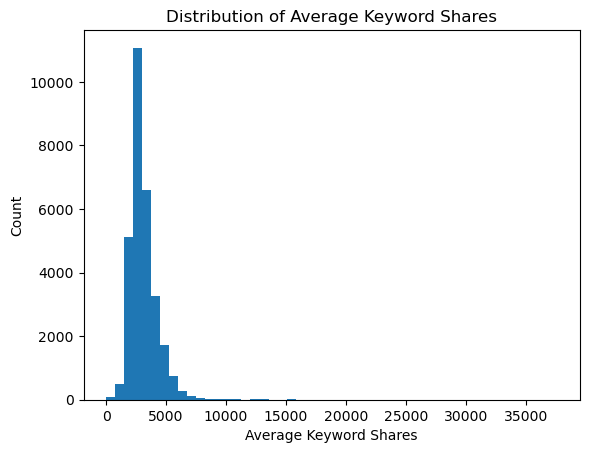

In [12]:
# Plottig the distribution of kw_avg_avg
plt.hist(data['kw_avg_avg'], bins=50)

plt.xlabel('Average Keyword Shares')
plt.ylabel('Count')
plt.title('Distribution of Average Keyword Shares')

plt.show()

Similar to `n_tokens_content` we have a distribution that is somewhat normal but has a very long right tail.

## Feature Engineering
Some feature engineering will be performed on the data to account for any non-linearity in the data as well as potentially capture additional information that is not being captured by the base data points. All feature engineered variables will begin with the `f_` tag.

One such thing would be examine the distribution of log values for `n_tokens_content` and `kw_avg_avg` to see if it creates a more normal distribution along with taking quadratics of certain variables to capture potential non-linearity in the data, as mentioned above.

C:\Users\Xrona\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


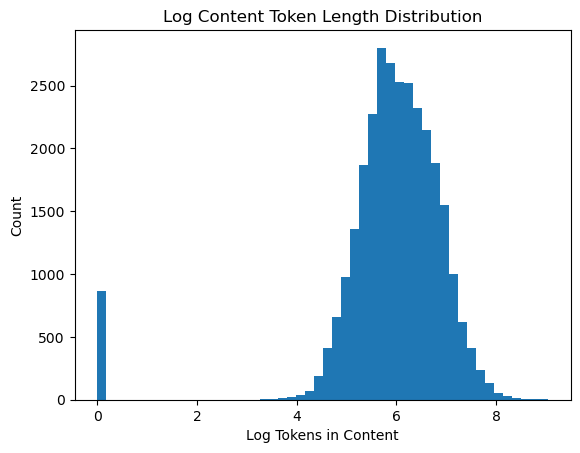

In [13]:
# Checking the distribution plot for the log values of n_tokens_content, setting the values to 0 where 
plt.hist(np.where(data['n_tokens_content'] == 0, 0, np.log(data['n_tokens_content'])), bins=50)

plt.xlabel('Log Tokens in Content')
plt.ylabel('Count')
plt.title('Log Content Token Length Distribution')

plt.show()

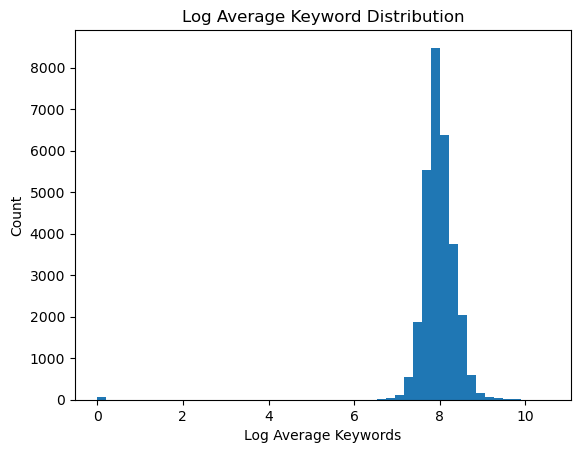

In [14]:
# Performing the same task for kw_avg_avg
plt.hist(np.where(data['kw_avg_avg'] == 0, 0, np.log(data['kw_avg_avg'])), bins=50)

plt.xlabel('Log Average Keywords')
plt.ylabel('Count')
plt.title('Log Average Keyword Distribution')

plt.show()

For occurrences where the number of tokens was equal to 0 the value of 0 was imputted for the log. The warnings generated are not actual issues. The log transformations of `n_tokens_content` and `kw_avg_avg` create more normal distributions and therefore will be used.

In [15]:
# Creating the log values as specified
data['f_log_tokens_content'] = np.where(data['n_tokens_content'] == 0, 0, np.log(data['n_tokens_content']))
data['f_log_kw_avg_avg'] = np.where(data['kw_avg_avg'] == 0, 0, np.log(data['kw_avg_avg']))

# Creating quadratic variables
data['f_n_tokens_title_sq'] = np.power(data['n_tokens_title'], 2)
data['f_num_imgs_sq'] = np.power(data['num_imgs'], 2)
data['f_num_keywords'] = np.power(data['num_keywords'], 2)

# Creating ratio variables
data['f_global_pos_neg_word_ratio'] = np.where((data['global_rate_positive_words'] > 0) & (data['global_rate_negative_words'] == 0), 1,  # Set ratio to 1 when pos words > 0 and neg words = 0
                                          np.where((data['global_rate_positive_words'] == 0) & (data['global_rate_negative_words'] == 0), 0,  # Set ratio to 0 when pos words = 0 and neg words = 0
                                               data['global_rate_positive_words'] / data['global_rate_negative_words']))  # Calculate ratio normally
data['f_token_img_ratio'] = np.where((data['n_tokens_content'] > 0) & (data['num_imgs'] == 0), 1,  # Set ratio to 1 when n_tokens_content > 0 and num_imgs = 0
                              np.where((data['n_tokens_content'] == 0) & (data['num_imgs'] == 0), 0,  # Set ratio to 0 when n_tokens_content = 0 and num_imgs = 0
                                   data['n_tokens_content'] / data['num_imgs']))  # Calculate ratio normally
data['f_token_video_ratio'] = np.where((data['n_tokens_content'] > 0) & (data['num_videos'] == 0), 1,  # Set ratio to 1 when n_tokens_content > 0 and num_videos = 0
                                  np.where((data['n_tokens_content'] == 0) & (data['num_videos'] == 0), 0,  # Set ratio to 0 when n_tokens_content = 0 and num_videos = 0
                                       data['n_tokens_content'] / data['num_videos']))  # Calculate ratio normally

# Creating additional feature engineered variables
data['f_avg_polarity'] = data['avg_positive_polarity'] + data['avg_negative_polarity'] # Showing the overall average polarity of the article

C:\Users\Xrona\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Training, Validation, and Test Splits

The training and test splits for creating models will be created using `is_popular` as the target variable. A 80/20% split will be made of the data to create a training and test split for OLS and machine learing models like Random Forest and Gradient Boosting models. A pseudo-random seed will be generated using the due date for the Kaggle competition as the seed number (20240419).

For the train_test_split the `stratify` parameter will be used in order to preserve the the distribution of `is_popular` given that it number of popular articles is inbalanced in the dataset.

In [16]:
# Importing required function
from sklearn.model_selection import train_test_split

# Setting the pseudo random seed
prng = np.random.RandomState(20240419)

# Creating X and y variables for splitting
X = data.drop(columns=['is_popular'])
y = data['is_popular']

# Creating initial training/test split of data, using stratify to preserve distribution of is_popular
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=prng)

## Benchmark and Base Feature OLS Models
The benchmark and OLS models will be created below.

### Benchmark Model
A simple benchmark model simply using the mean value of `is_popular` will be used.

In [17]:
# Importing required function
from sklearn.metrics import roc_auc_score

# Creating benchmark model
benchmark = np.mean(y_train)

# Calculating the AUC scores for the benchmark model
train_auc = roc_auc_score(y_train, np.repeat(benchmark, len(y_train)))
test_auc = roc_auc_score(y_test, np.repeat(benchmark, len(y_test)))
benchmark_pred = ['Benchmark', train_auc, test_auc]

# Storing and displaying results in a dataframe
results = pd.DataFrame([benchmark_pred], columns = ['Model', 'Train AUC', 'Test AUC'])
results

,Model,Train AUC,Test AUC
0,Benchmark,0.5,0.5


The results of the benchmark model is .5 forboth the training and test sets. This means that it doesn't do any better than predicting the outcome randomly. This makes it a perfect benchmark model.

### Single Feature Logit
This model will only include a single feature and will be used as the benchmark going forward. The feature selected will be `d_weekend` as the day of the week seems to be a significant predictor for popularity. ll predictions are made for probabilities. This means using `predict_proba()` instead of `predict()`. Grabbing the `[:,1]` element of the probability is to denote the prediction of the probability that the article is popular.

In [18]:
# Importing required functions
from sklearn.linear_model import LogisticRegression

# Creating a logistic regression model and fitting it to the data
logit_single = LogisticRegression().fit(X_train[['kw_avg_avg']], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, logit_single.predict_proba(X_train[['kw_avg_avg']])[:,1])
test_auc = roc_auc_score(y_test, logit_single.predict_proba(X_test[['kw_avg_avg']])[:,1])
logit_single_pred = ['Single Feature Logit', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = logit_single_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501


The single feature logit model is doing a much better job than the benchmark. It appears that using a single feature `kw_avg_avg` is a decent predictor and is better than a random prediction of popularity. `kw_avg_avg` is the average shares of the average keyword in the article and it looks like this is a decent predictor to use.

### Logit Using All Base Features

In [19]:
# Creating list of base features for model selection from the dataset
base_features = [col for col in X_train.columns if col not in exclude_cols and not col.startswith('f_')]

# Creating and fitting the model, setting max iterations to 3000 to allow convergence
logit_base = LogisticRegression(max_iter=3000).fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, logit_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, logit_base.predict_proba(X_test[base_features])[:,1])
logit_base_pred = ['Logit Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = logit_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286


Using all the base features does a worse job than only 1 feature. It seems like some of the features in the dataset are adding noise to the model and making a worse prediction.

### LASSO All Base Features

In [20]:
# Creating the LASSO model
lasso_base = LogisticRegression(penalty='l1', solver='liblinear', max_iter=3000).fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, lasso_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, lasso_base.predict_proba(X_test[base_features])[:,1])
lasso_base_pred = ['LASSO Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = lasso_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494


The LASSO on the base features seems to have corrected for some of the noise in the base features because it produced a better AUC score on the test set than the single feature logit. The L1 penalty has reduced the coefficients of features that are less meaningful and more noisy and produced a better result.

### Logit with Interaction Terms on Base Features
First order interactions only will be used (no quadratics) on only base features.

In [21]:
# Importing required method
from sklearn.preprocessing import PolynomialFeatures

# Creating interaction terms in training data
interactions = PolynomialFeatures(degree=1, interaction_only=True)
X_train_base_interactions = interactions.fit_transform(X_train[base_features])

# Fitting Logit model to training data with interaction terms
logit_base_interactions = LogisticRegression(max_iter=3000).fit(X_train_base_interactions, y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, logit_base_interactions.predict_proba(X_train_base_interactions)[:,1])
test_auc = roc_auc_score(y_test, logit_base_interactions.predict_proba(interactions.transform(X_test[base_features]))[:,1])
logit_base_interactions_pred = ['Logit Base Interactions', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = logit_base_interactions_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688


First order interaction terms on the base features gave virtually the same score as the Logit base features model. Adding interaction terms does not seem to be affecting the model at all.

### LASSO Version of Previous Model

In [22]:
# Tweaking the previous model to turn it into a LASSO
lasso_base_interactions = LogisticRegression(penalty='l1', solver='liblinear', max_iter=3000).fit(X_train_base_interactions, y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, lasso_base_interactions.predict_proba(X_train_base_interactions)[:,1])
test_auc = roc_auc_score(y_test, lasso_base_interactions.predict_proba(interactions.transform(X_test[base_features]))[:,1])
lasso_base_interactions_pred = ['LASSO Base Interactions', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = lasso_base_interactions_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562


Adding interaction terms very marginally decreased the AUC score on the test set from the LASSO model without interaction terms. This further shows that adding interaction terms to the model increases complexity with no actual gain. Going forward the interaction terms will not be used.

## Base Feature Machine Learing Models
Below Machine Learing models using exclusively base features will be created. Since there are no categorical variables in the training/test data being used there will be no need for a pipeline 

### Random Forest Base Features
Creating a Random Forest model with a minimum sample split of 20 to prevent overfitting.

In [23]:
# Importing required method
from sklearn.ensemble import RandomForestClassifier

# Creating and fitting the RF to training data using prng defined earlier. Parameters set to prevent overfitting
rf_base = RandomForestClassifier(min_samples_split=20, random_state=prng).fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, rf_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, rf_base.predict_proba(X_test[base_features])[:,1])
rf_base_pred = ['RF Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = rf_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268


From the scores we can see the RF model performs almost perfectly on the training set. This is not usually desirable as it likely means that the model is overfitting to the training set. From the test AUC scores the RF model has performed the best so far but is a clear dropoff from the training AUC score, meaning that the RF model is indeed overfitting despite some effort to prevent it. Despite this, so far the RF model is doing the best job of predicting article popularity.

### Gradient Boosting Machine Base Features
As with the RF model, `min_samples_split` set to 20 to avoid overfitting.

In [24]:
# Importing required method
from sklearn.ensemble import GradientBoostingClassifier

# Creating and fitting GBM to training
gbm_base = GradientBoostingClassifier(min_samples_split=20, random_state=prng).fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, gbm_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, gbm_base.predict_proba(X_test[base_features])[:,1])
gbm_base_pred = ['GBM Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = gbm_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268
7,GBM Base Features,0.764418,0.704333


From the scores the GBM model has a more appropriate train AUC score than the RF model and also performs very slightly better on the Test AUC. The GBM model is doing a better job of regularization on the training set which is resulting in a (marginally) better test AUC score.

### XGBoost Base Features
A different boosting model will be attempted.

In [25]:
# Importing required method
from xgboost import XGBClassifier

# Creating and fitting XGB to training set
xgb_base = XGBClassifier().fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, xgb_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, xgb_base.predict_proba(X_test[base_features])[:,1])
xgb_base_pred = ['XGB Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = xgb_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268
7,GBM Base Features,0.764418,0.704333
8,XGB Base Features,0.991668,0.680205


From these results it appears that the XGBoost model performs similarly to the RF model except with a worse test AUC score which means it does a worse job of predicting popularity of articles than either of the two machine learning models. It is doing worse than the linear models as well.

## Base Feature Fully Connected Neural Network Models
Below some neural network models will be created using only base features. A sigmoid layer will be used as the output layer for all models given that the classification task is for a binary target variable. Prior to creating any neural network models, however, a new split of the data will need to be done to create a validation set. Along with this, the data will need to be scaled using `StandardScaler()` in order to regularize the data to make the neural network models function better.

In [26]:
# Importing required method
from sklearn.preprocessing import StandardScaler

# Creating new training and validation splits from X_train
nnX_train, nnX_val, nny_train, nny_val = train_test_split(X_train, y_train, test_size=.2, stratify=y_train, random_state=prng)

# Applying StandardScaler base features of these new splits along with X_test
nnX_train_base_scaled = StandardScaler().fit_transform(nnX_train[base_features])
nnX_val_base_scaled = StandardScaler().fit_transform(nnX_val[base_features])
X_test_base_scaled = StandardScaler().fit_transform(X_test[base_features])

### Single RelU Hidden Layer

In [27]:
# Importing required methods
from keras.utils import set_random_seed
from keras.models import Sequential
from keras.layers import Input, Dense

# Setting the random seed for all neural network models for reproducibility, using same seed number as above
set_random_seed(20240419)

# Creating the model
relu_hidden = Sequential([
    Input(shape=nnX_train_base_scaled.shape[1:]),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
relu_hidden.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
relu_hidden.fit(nnX_train_base_scaled, nny_train, validation_data=(nnX_val_base_scaled, nny_val), epochs=20, batch_size=128)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(nny_train, relu_hidden.predict(nnX_train_base_scaled))
test_auc = roc_auc_score(y_test, relu_hidden.predict(X_test_base_scaled))
relu_hidden_pred = ['RelU Hidden Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = relu_hidden_pred
results

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8397 - loss: 0.4453 - val_accuracy: 0.8781 - val_loss: 0.3460
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8754 - loss: 0.3547 - val_accuracy: 0.8775 - val_loss: 0.3425
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8756 - loss: 0.3486 - val_accuracy: 0.8775 - val_loss: 0.3404
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8757 - loss: 0.3448 - val_accuracy: 0.8777 - val_loss: 0.3393
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8759 - loss: 0.3419 - val_accuracy: 0.8775 - val_loss: 0.3387
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8761 - loss: 0.3398 - val_accuracy: 0.8775 - val_loss: 0.3383
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8763 - loss: 0.3380 - val_accuracy: 0.8775 - val_loss: 0.3382
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8769 - loss: 0.3365 - val_accuracy: 0.

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268
7,GBM Base Features,0.764418,0.704333
8,XGB Base Features,0.991668,0.680205
9,RelU Hidden Base Features,0.767825,0.694809


This initial neural network model performed very well, only doing worse than the GBM model. The preprocessing done with a standard scaler made the data easier for the neural network model to handle and it did a good job of predicting popularity.

### Two Hidden RelU Layers, 256 Nodes Each

In [28]:
# Creating the model
two_relu_256 = Sequential([
    Input(shape=nnX_train_base_scaled.shape[1:]),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
two_relu_256.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
two_relu_256.fit(nnX_train_base_scaled, nny_train, validation_data=(nnX_val_base_scaled, nny_val), epochs=20, batch_size=128)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(nny_train, two_relu_256.predict(nnX_train_base_scaled))
test_auc = roc_auc_score(y_test, two_relu_256.predict(X_test_base_scaled))
two_relu_256_pred = ['Two Relu 256 Hidden Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = two_relu_256_pred
results

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8646 - loss: 0.3944 - val_accuracy: 0.8781 - val_loss: 0.3436
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8756 - loss: 0.3476 - val_accuracy: 0.8779 - val_loss: 0.3424
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.3407 - val_accuracy: 0.8783 - val_loss: 0.3423
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8773 - loss: 0.3358 - val_accuracy: 0.8777 - val_loss: 0.3428
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8776 - loss: 0.3312 - val_accuracy: 0.8770 - val_loss: 0.3433
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8787 - loss: 0.3265 - val_accuracy: 0.8770 - val_loss: 0.3442
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8797 - loss: 0.3217 - val_accuracy: 0.8752 - val_loss: 0.3460
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8804 - loss: 0.3160 - val_accuracy: 0.

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268
7,GBM Base Features,0.764418,0.704333
8,XGB Base Features,0.991668,0.680205
9,RelU Hidden Base Features,0.767825,0.694809


In an attempt to make the model much more complex in order to better capture the data, it appears to have backfired by providing a significantly worse AUC score than the initial neural network model. Adding more complexity did not help in this instance and caused an overfit. A version of the initial model with fewer RelU nodes will be created next.

### Simpler Hidden Layer, Fewer RelU Nodes

In [29]:
# Creating the model
relu_base_50 = Sequential([
    Input(shape=nnX_train_base_scaled.shape[1:]),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
relu_base_50.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
relu_base_50.fit(nnX_train_base_scaled, nny_train, validation_data=(nnX_val_base_scaled, nny_val), epochs=20, batch_size=128)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(nny_train, relu_base_50.predict(nnX_train_base_scaled))
test_auc = roc_auc_score(y_test, relu_base_50.predict(X_test_base_scaled))
relu_base_50_pred = ['RelU 50 Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = relu_base_50_pred
results

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6621 - loss: 0.6323 - val_accuracy: 0.8770 - val_loss: 0.3515
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8754 - loss: 0.3617 - val_accuracy: 0.8768 - val_loss: 0.3465
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8759 - loss: 0.3559 - val_accuracy: 0.8766 - val_loss: 0.3446
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.8759 - loss: 0.3523 - val_accuracy: 0.8766 - val_loss: 0.3432
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8760 - loss: 0.3495 - val_accuracy: 0.8770 - val_loss: 0.3423
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.8759 - loss: 0.3473 - val_accuracy: 0.8770 - val_loss: 0.3415
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8759 - loss: 0.3455 - val_accuracy: 0.8773 - val_loss: 0.3409
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.8758 - loss: 0.3439 - val_accura

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268
7,GBM Base Features,0.764418,0.704333
8,XGB Base Features,0.991668,0.680205
9,RelU Hidden Base Features,0.767825,0.694809


Making the model even simpler produced almost the same result but slightly worse AUC score on the test set. It may be that being too simple may not be the best option.

## Feature Engineering Trained Models
Below will be models created above but trained on feature engineered data instead. Feature Engineered data will be all the features from the data but will be run off of a LASSO shortlisted variable set.

Only the better performing models will be used for the purposes of this exercise.

### Feature Engineered LASSO

In [30]:
# Creating LASSO model for FE
lasso_fe = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000).fit(X_train, y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, lasso_fe.predict_proba(X_train)[:,1])
test_auc = roc_auc_score(y_test, lasso_fe.predict_proba(X_test)[:,1])
lasso_fe_pred = ['LASSO FE', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = lasso_fe_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.664115,0.668501
2,Logit Base Features,0.605131,0.605286
3,LASSO Base Features,0.688254,0.677494
4,Logit Base Interactions,0.605539,0.605688
5,LASSO Base Interactions,0.688507,0.677562
6,RF Base Features,0.998071,0.694268
7,GBM Base Features,0.764418,0.704333
8,XGB Base Features,0.991668,0.680205
9,RelU Hidden Base Features,0.767825,0.694809


Adding the feature engineered variables only slightly improved the AUC scores from the base features LASSO model meaning that there isn't much in the way of non-linearity that is either present in the data or captured by the FE terms. The shortlisted LASSO features will grab only the features that are truly meaningful from all features in the data after feature engineering for future models.

In [31]:
# Getting the list of LASSO shortlisted base features
lasso_fe_coef = lasso_fe.coef_[0]
lasso_fe_results = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_fe_coef})
lasso_fe_shortlist = lasso_fe_results[lasso_fe_results['Coefficient'] != 0]

# Setting names of shortlisted features to a variable
shortlist = lasso_fe_shortlist['Feature'].tolist()

# Disabling scientific notation
pd.set_option('display.float_format', lambda x: '%.7f' % x)

# Displaying shortlist dataframe
lasso_fe_shortlist

,Feature,Coefficient
0,timedelta,0.0007253
1,n_tokens_title,-0.0585358
2,n_tokens_content,0.0001733
3,n_unique_tokens,-0.0147360
4,n_non_stop_words,-0.4265798
5,n_non_stop_unique_tokens,-0.0612815
6,num_hrefs,0.0097897
7,num_self_hrefs,-0.0262251
8,num_imgs,0.0087920
9,num_videos,0.0147943


In [32]:
# Showing columns not included in LASSO shortlist (with threshold of +/- .1)
[col for col in X_train.columns if col not in shortlist]

['d_genre_world',
 'global_rate_negative_words',
 'avg_positive_polarity',
 'avg_negative_polarity']

This shortlist will be used going forward for all models.

### Feature Engineered RF

In [33]:
# Creating and fitting the RF to training data using prng defined earlier. Parameters set to prevent overfitting
rf_fe = RandomForestClassifier(min_samples_split=20, random_state=prng).fit(X_train[shortlist], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, rf_fe.predict_proba(X_train[shortlist])[:,1])
test_auc = roc_auc_score(y_test, rf_fe.predict_proba(X_test[shortlist])[:,1])
rf_fe_pred = ['RF FE', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = rf_fe_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.5000000,0.5000000
1,Single Feature Logit,0.6641153,0.6685011
2,Logit Base Features,0.6051313,0.6052865
3,LASSO Base Features,0.6882543,0.6774942
4,Logit Base Interactions,0.6055388,0.6056876
5,LASSO Base Interactions,0.6885074,0.6775620
6,RF Base Features,0.9980713,0.6942683
7,GBM Base Features,0.7644183,0.7043326
8,XGB Base Features,0.9916682,0.6802052
9,RelU Hidden Base Features,0.7678247,0.6948092


From the results the feature engineered RF model performed slightly better on the test set than the base features RF model. This is more evidence that the feature engineering is having a slight positive effect on the models.

### Feature Engineered Gradient Boosting Machine

In [34]:
# Creating and fitting GBM to training
gbm_fe = GradientBoostingClassifier(min_samples_split=20, random_state=prng).fit(X_train[shortlist], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, gbm_fe.predict_proba(X_train[shortlist])[:,1])
test_auc = roc_auc_score(y_test, gbm_fe.predict_proba(X_test[shortlist])[:,1])
gbm_fe_pred = ['GBM FE', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = gbm_fe_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.5000000,0.5000000
1,Single Feature Logit,0.6641153,0.6685011
2,Logit Base Features,0.6051313,0.6052865
3,LASSO Base Features,0.6882543,0.6774942
4,Logit Base Interactions,0.6055388,0.6056876
5,LASSO Base Interactions,0.6885074,0.6775620
6,RF Base Features,0.9980713,0.6942683
7,GBM Base Features,0.7644183,0.7043326
8,XGB Base Features,0.9916682,0.6802052
9,RelU Hidden Base Features,0.7678247,0.6948092


From the results the GBM model performed slightly better with the feature engineered data, and therefore produced the best test AUC score overall. It's a marginal improvement but an improvement nontheless. It looks like the featured engineered data does capture a bit of non-linearity in the data and that the GBM model is able to capture that, at least somewhat. The improvement is marginal but it does improve the model and will therefore be used.

### Feature Engineered Single Hidden RelU Layer

In [35]:
# Applying StandardScaler base features of these new splits along with X_test
nnX_train_shortlist_scaled = StandardScaler().fit_transform(nnX_train[shortlist])
nnX_val_shortlist_scaled = StandardScaler().fit_transform(nnX_val[shortlist])
X_test_shortlist_scaled = StandardScaler().fit_transform(X_test[shortlist])

# Creating the model
relu_fe = Sequential([
    Input(shape=nnX_train_shortlist_scaled.shape[1:]),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
relu_fe.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
relu_fe.fit(nnX_train_shortlist_scaled, nny_train, validation_data=(nnX_val_shortlist_scaled, nny_val), epochs=20, batch_size=128)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(nny_train, relu_fe.predict(nnX_train_shortlist_scaled))
test_auc = roc_auc_score(y_test, relu_fe.predict(X_test_shortlist_scaled))
relu_fe_pred = ['RelU FE', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = relu_fe_pred
results

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7049 - loss: 0.5673 - val_accuracy: 0.8785 - val_loss: 0.3463
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8745 - loss: 0.3558 - val_accuracy: 0.8781 - val_loss: 0.3420
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.8750 - loss: 0.3473 - val_accuracy: 0.8770 - val_loss: 0.3400
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8751 - loss: 0.3415 - val_accuracy: 0.8768 - val_loss: 0.3390
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8757 - loss: 0.3374 - val_accuracy: 0.8768 - val_loss: 0.3385
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8767 - loss: 0.3340 - val_accuracy: 0.8770 - val_loss: 0.3381
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8768 - loss: 0.3314 - val_accuracy: 0.8768 - val_loss: 0.3379
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.8773 - loss: 0.3291 - val_accurac

,Model,Train AUC,Test AUC
0,Benchmark,0.5000000,0.5000000
1,Single Feature Logit,0.6641153,0.6685011
2,Logit Base Features,0.6051313,0.6052865
3,LASSO Base Features,0.6882543,0.6774942
4,Logit Base Interactions,0.6055388,0.6056876
5,LASSO Base Interactions,0.6885074,0.6775620
6,RF Base Features,0.9980713,0.6942683
7,GBM Base Features,0.7644183,0.7043326
8,XGB Base Features,0.9916682,0.6802052
9,RelU Hidden Base Features,0.7678247,0.6948092


For the neural network model adding the feature engineered data caused it to perform only slightly better than the base features version, and worse than the GBM model. Intuitively this makes sense since the data may not be complex enough for a neural network to outperform other model types, including a GBM model that is designed for situations where data may be more simplistic in nature.

## Analysis and Conclusion

From looking at the perfomance of all the models the GBM model appears to perform the best for this dataset. This is likely due to GBM's unique method of robustness to overfitting with regularization techniques like shrinkage being applied to prevent memorization of the training data that other models like the Random Forest and Neural Network models don't apply.

When examining the feature engineered variables using the LASSO shortlist a positive effect is shown on the prediction power, albeit not greatly. This means that while capturing some additional patterns in the data, the feature engineering does not significantly alter the prediction power. That being said, the GBM model takes the most advantage of the feature engineering to produce the best score from the set.

The overall conclusion is that the GBM model created on the feature engineered data is the best model for making a prediction to submit towards the Kaggle competition.

### Generating Kaggle submission
The Kaggle submission is to be generated using the model on the data from `test.csv` downloaded from the competition page and generating a submission file that has the `article_id` as the index and the prediction probabilities genreated for each observation as the `score` column.

The same feature engineering will need to be done to the kaggle test data to allow the model to predict correctly.

In [36]:
# Loading the test.csv data from Kaggle
test_data = pd.read_csv('test.csv', index_col='article_id')

# Performing the same methods to the test data to make the FE model run
test_data['d_mon_tues'] = test_data['weekday_is_monday'] + test_data['weekday_is_tuesday']
test_data.rename(columns={'is_weekend': 'd_weekend'}, inplace=True)
test_data.drop(columns=weekdays, inplace=True)
[test_data.rename(columns={genre: genre.replace('data_channel_is_', 'd_genre_')}, inplace=True) for genre in genres]
test_data['d_no_words'] = (test_data['average_token_length'] == 0).astype(int)

test_data['f_log_tokens_content'] = np.where(test_data['n_tokens_content'] == 0, 0, np.log(test_data['n_tokens_content']))
test_data['f_log_kw_avg_avg'] = np.where(test_data['kw_avg_avg'] == 0, 0, np.log(test_data['kw_avg_avg']))
test_data['f_n_tokens_title_sq'] = np.power(test_data['n_tokens_title'], 2)
test_data['f_num_imgs_sq'] = np.power(test_data['num_imgs'], 2)
test_data['f_num_keywords'] = np.power(test_data['num_keywords'], 2)
test_data['f_global_pos_neg_word_ratio'] = np.where((test_data['global_rate_positive_words'] > 0) & (test_data['global_rate_negative_words'] == 0), 1,
                                          np.where((test_data['global_rate_positive_words'] == 0) & (test_data['global_rate_negative_words'] == 0), 0,
                                               test_data['global_rate_positive_words'] / test_data['global_rate_negative_words']))
test_data['f_token_img_ratio'] = np.where((test_data['n_tokens_content'] > 0) & (test_data['num_imgs'] == 0), 1,
                              np.where((test_data['n_tokens_content'] == 0) & (test_data['num_imgs'] == 0), 0,
                                   test_data['n_tokens_content'] / test_data['num_imgs']))
test_data['f_token_video_ratio'] = np.where((test_data['n_tokens_content'] > 0) & (test_data['num_videos'] == 0), 1,
                                  np.where((test_data['n_tokens_content'] == 0) & (test_data['num_videos'] == 0), 0,
                                       test_data['n_tokens_content'] / test_data['num_videos']))
test_data['f_avg_polarity'] = test_data['avg_positive_polarity'] + test_data['avg_negative_polarity']

# Creating predictions using the test data from Kaggle
gbe_fe_kaggle_pred = gbm_fe.predict_proba(test_data[shortlist])[:,1]

# Creating submission file per specifications using date created in filename
pd.DataFrame(gbe_fe_kaggle_pred, columns=['score'], index=test_data.index).to_csv('submission_nf_20240418.csv')

C:\Users\Xrona\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Xrona\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
